In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.feature_extraction.text import HashingVectorizer

import re
import emoji
import string

In [2]:
# Load data
df = pd.read_csv('cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [3]:
df.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


### Simple Analysis

In [4]:
# Get info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
# Check for null value
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
# Check for duplicates
df["tweet_text"].duplicated().sum()

1675

In [7]:
# Drop duplicates
df.drop_duplicates("tweet_text", inplace=True)

In [8]:
# Renaming columns for better understanding
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
# Let's check for the classes of our sentiment and how they're distributed
df['sentiment'].value_counts()

religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: sentiment, dtype: int64

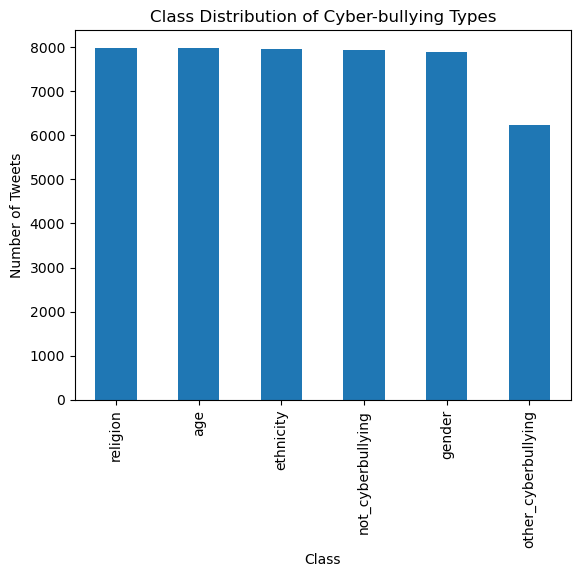

In [10]:
# Create a bar plot of the class distribution
class_counts = df['sentiment'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyber-bullying Types')
plt.xlabel('Class')
plt.ylabel('Number of Tweets')
plt.show()

### Text Pre-processing

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
# remove emoji from text if any
def strip_emoji(text):
    return emoji.demojize(text, delimiters=("", ""))

In [13]:
# convert text to uppercase, remove url, user mentions, digits, punctuation, stop
def strip_all_entities(text):
    # Replace carriage returns and newlines with spaces, and convert to lowercase
    text = text.replace('\r', '').replace('\n', ' ').lower()

    # Remove URLs and user mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', r'', text)

    # Remove digits
    text = re.sub('[0-9]+', '', text)

    # Remove punctuation
    stopchars = string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)

    # Remove stop words
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

In [14]:
def filter_chars(a):
    sent = []
    # Iterate through words in the input text
    for word in a.split(' '):
        # If the word contains '$' or '&', replace it with an empty string
        if ('$' in word) or ('&' in word):
            sent.append('')
        # Otherwise, keep the word
        else:
            sent.append(word)
    # Join the filtered words back into a single string
    return ' '.join(sent)

In [15]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

In [16]:
def decontract(text):
    # Define a dictionary of contractions and their expanded forms
    contractions = {
        "can't": "can not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am",
        "'u": " you"
    }

    # Use a regular expression to find contractions and replace them with their expanded forms
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    return text

In [17]:
def remove_mult_spaces(text):
    # Replace multiple consecutive spaces with a single space
    return re.sub("\s\s+", " ", text)

In [18]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokenized_text = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return ' '.join(lemmatized_text)

In [19]:
### Applying all above function on our text
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = lemmatize_text(text)
    return text

In [20]:
df['cleaned_text'] = df['text'].apply(preprocess)
df.head()

,text,sentiment,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [21]:
# Tokenize text
def tokenize(text):
    # Split the text into words using regular expressions
    tokens = re.findall(r'\b\w+\b', text)
    return tokens
df['tokenized_text'] = df['cleaned_text'].apply(tokenize)

In [22]:
df.head()

,text,sentiment,cleaned_text,tokenized_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,"[word, katandandre, food, crapilicious, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,"[classy, whore, red, velvet, cupcake]"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...,"[meh, p, thanks, head, concerned, another, ang..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,"[isi, account, pretending, kurdish, account, l..."


In [23]:
### Word Count

# Combine all the tokens into a single list
all_tokens = [token for tokens in df['tokenized_text'] for token in tokens]

# Count the frequency of each word
word_counts = Counter(all_tokens)

# Get the top 100 most common words
top_words = word_counts.most_common(100)

print(top_words)

[('school', 9149), ('fuck', 6069), ('like', 5900), ('nigger', 5619), ('girl', 5524), ('joke', 5504), ('u', 5404), ('dumb', 5334), ('bully', 5323), ('high', 5096), ('people', 4822), ('muslim', 4767), ('bullied', 4667), ('gay', 4360), ('rape', 4261), ('rt', 4147), ('one', 3689), ('idiot', 3465), ('woman', 3163), ('get', 3039), ('black', 2855), ('as', 2794), ('would', 2591), ('amp', 2569), ('bitch', 2519), ('mkr', 2518), ('know', 2455), ('white', 2301), ('think', 2268), ('make', 2234), ('right', 2202), ('say', 2195), ('christian', 2155), ('call', 1897), ('go', 1849), ('got', 1827), ('time', 1749), ('im', 1725), ('dont', 1683), ('fucking', 1672), ('even', 1626), ('want', 1605), ('see', 1523), ('ur', 1510), ('shit', 1509), ('never', 1500), ('called', 1491), ('thing', 1470), ('terrorist', 1445), ('still', 1406), ('year', 1392), ('hate', 1391), ('really', 1388), ('support', 1322), ('first', 1320), ('islam', 1301), ('need', 1295), ('said', 1285), ('islamic', 1280), ('look', 1268), ('obama', 12

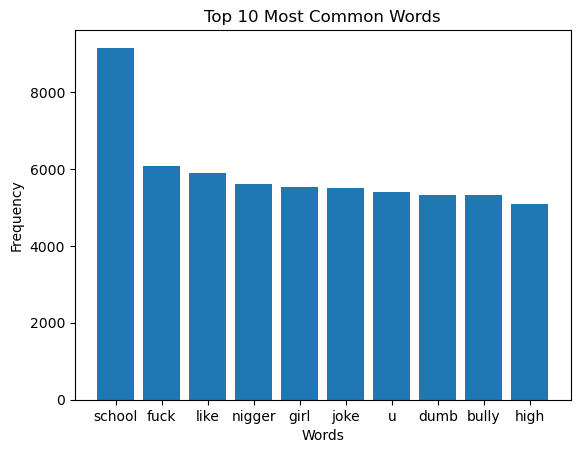

In [24]:
# Plot barchart for the ten most common word
# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Plot the bar chart
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')

plt.show()

In [25]:
text_len = []
for text in df.tokenized_text:
    tweet_len = len(text)
    text_len.append(tweet_len)
df['text_len'] = text_len

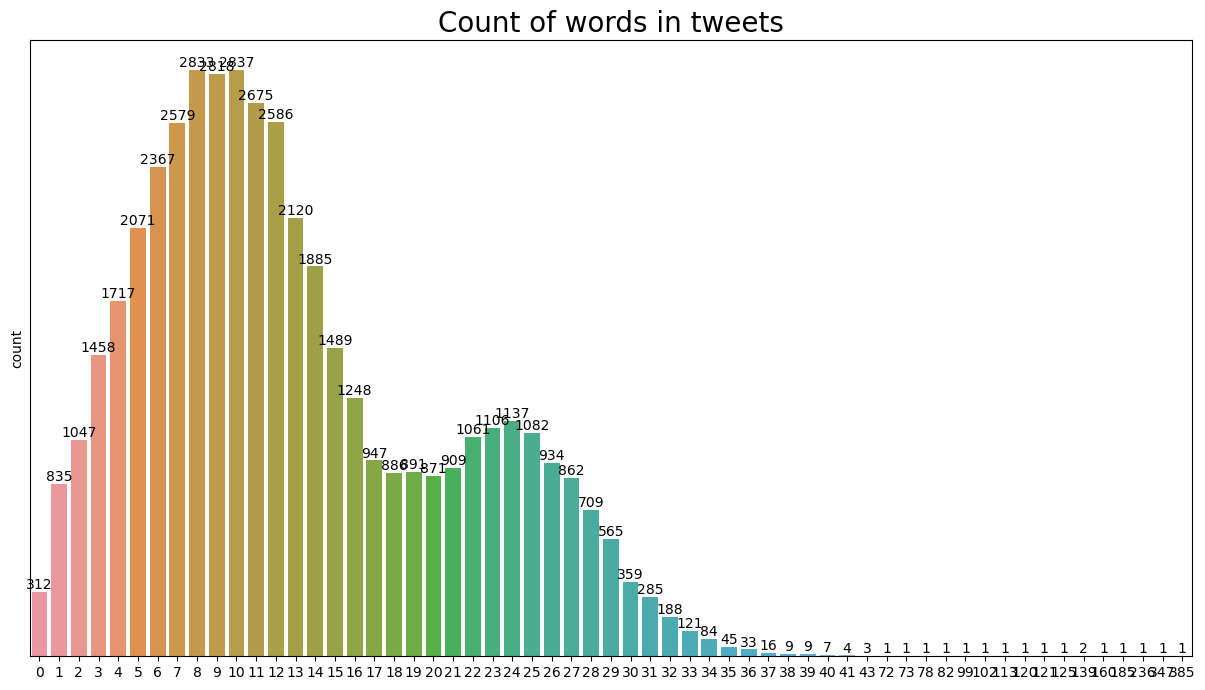

In [26]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df)
plt.title('Count of words in tweets', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [27]:
df.head()

,text,sentiment,cleaned_text,tokenized_text,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,"[word, katandandre, food, crapilicious, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,"[classy, whore, red, velvet, cupcake]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...,"[meh, p, thanks, head, concerned, another, ang...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,"[isi, account, pretending, kurdish, account, l...",8


In [28]:
df['tokenized_text'][26]

['isso', 'bullying']

In [29]:
# remove text with words less than or equal to one
df = df[df['text_len'] > 1]
df.head()

,text,sentiment,cleaned_text,tokenized_text,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,"[word, katandandre, food, crapilicious, mkr]",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,"[classy, whore, red, velvet, cupcake]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...,"[meh, p, thanks, head, concerned, another, ang...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,"[isi, account, pretending, kurdish, account, l...",8


In [30]:
df.shape

(44870, 5)

### Visualizing with wordcloud

In [31]:
df['sentiment'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [32]:
# SPlitting data based on sentiment
df_not_cyberbullying = df[df['sentiment'] == 'not_cyberbullying']
df_gender = df[df['sentiment'] == 'gender']
df_religion = df[df['sentiment'] == 'religion']
df_other_cyberbullying = df[df['sentiment'] == 'other_cyberbullying']
df_age = df[df['sentiment'] == 'age']
df_ethnicity = df[df['sentiment'] == 'ethnicity']

##### Tweets that are not cyberbullying

In [33]:
not_cyberbullying = Counter([item for sublist in df_not_cyberbullying['tokenized_text'] for item in sublist])
top10_not_cyberbullying = pd.DataFrame(not_cyberbullying.most_common(15))
top10_not_cyberbullying.columns = ['Top Words', 'Count']
top10_not_cyberbullying.style.background_gradient(cmap='Reds')

,Top Words,Count
0,mkr,1676
1,rt,780
2,bullying,689
3,like,401
4,bully,386
5,school,370
6,get,353
7,kat,289
8,would,285
9,people,273


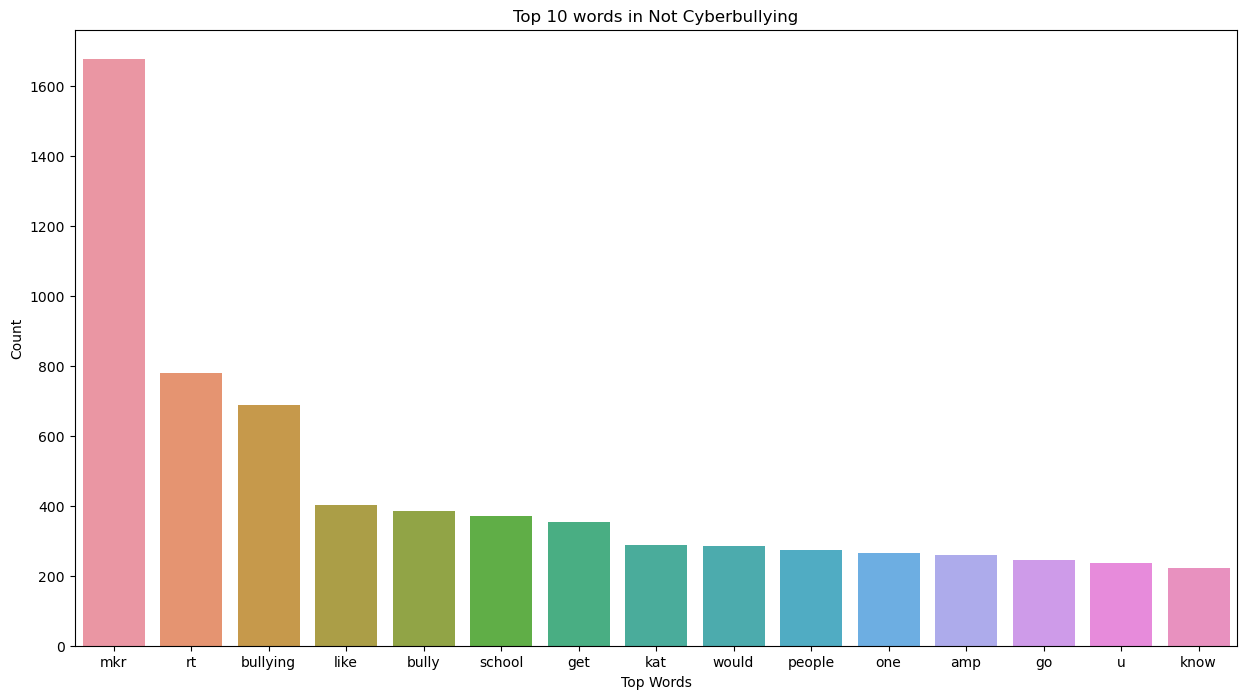

In [34]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top10_not_cyberbullying, y="Count", x="Top Words")
plt.title("Top 10 words in Not Cyberbullying")
plt.show()

In [35]:
# Function to plot wordcloud
def plot_wordcloud(cyberbullying_type, df):
    string = ""
    for i in df[df.sentiment == cyberbullying_type].cleaned_text.values:
        string = string + " " + i.strip()

    wordcloud = WordCloud(background_color ='white', max_words=2000, max_font_size=256,
                          random_state=42, width=800, height=800, min_font_size = 10).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(cyberbullying_type)
    plt.show()
    del string

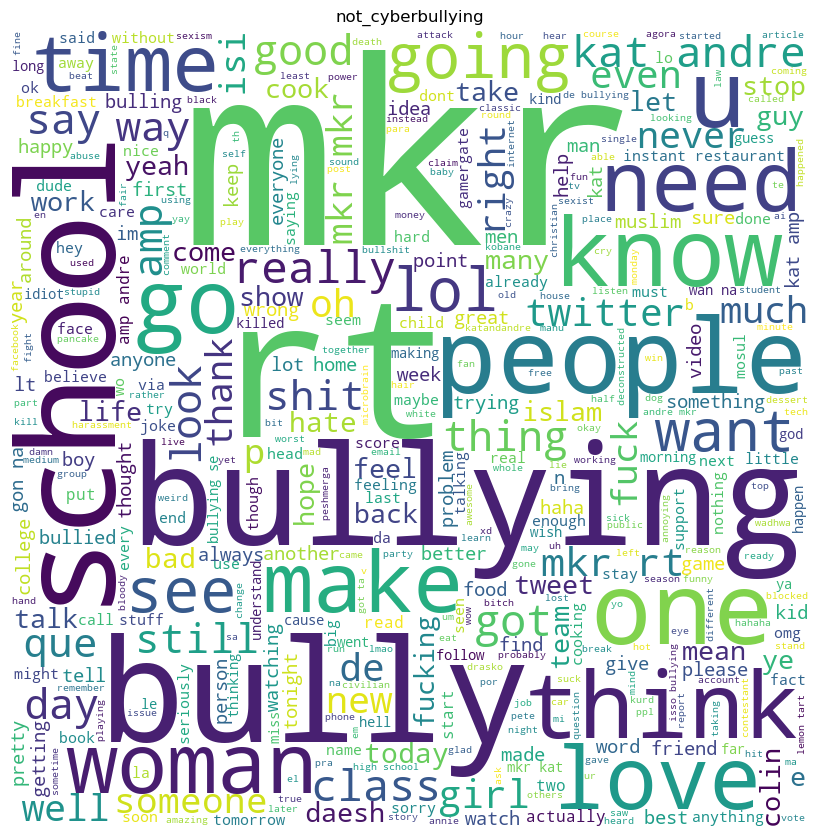

In [36]:
plot_wordcloud('not_cyberbullying', df)

#### Cyberbullying that are gender based

In [37]:
gender = Counter([item for sublist in df_gender['tokenized_text'] for item in sublist])
top10_gender = pd.DataFrame(gender.most_common(15))
top10_gender.columns = ['Top Words', 'Count']
top10_gender.style.background_gradient(cmap='Reds')

,Top Words,Count
0,joke,5295
1,rape,4097
2,gay,4007
3,rt,1233
4,woman,1184
5,bitch,1154
6,call,1111
7,female,1108
8,people,997
9,sexist,955


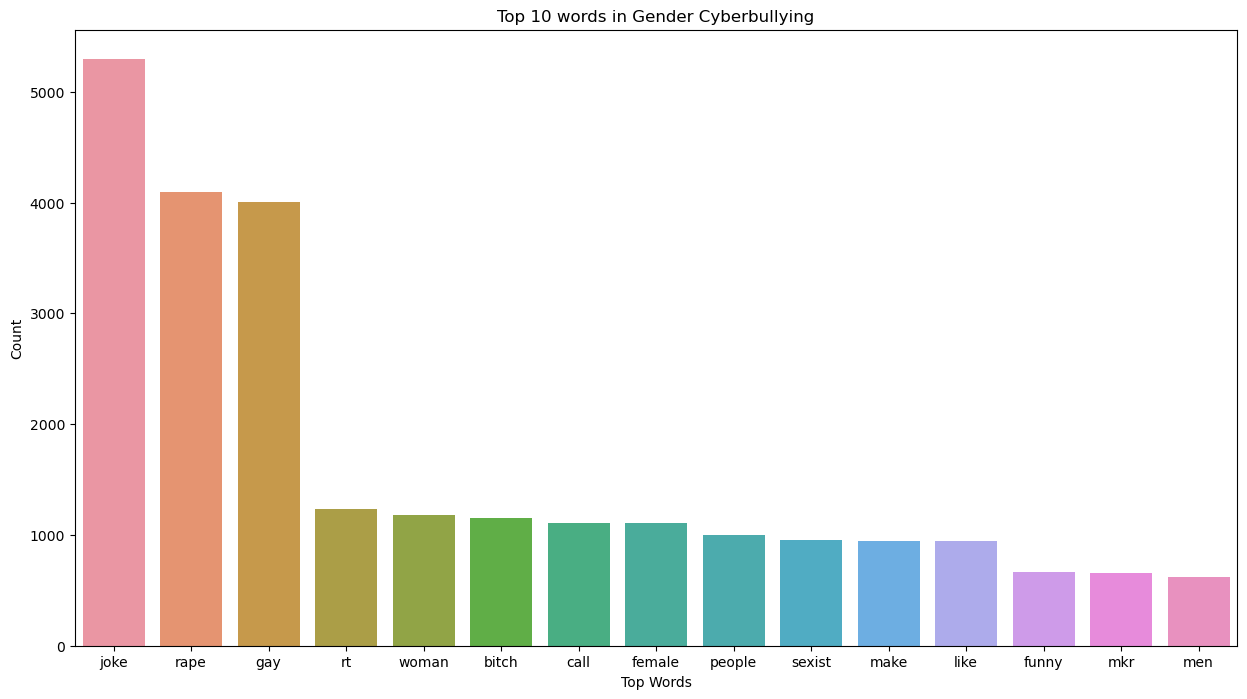

In [38]:
fig = plt.figure(figsize=(15,8))
sns.barplot(data=top10_gender, y="Count", x="Top Words")
plt.title("Top 10 words in Gender Cyberbullying")
plt.show()

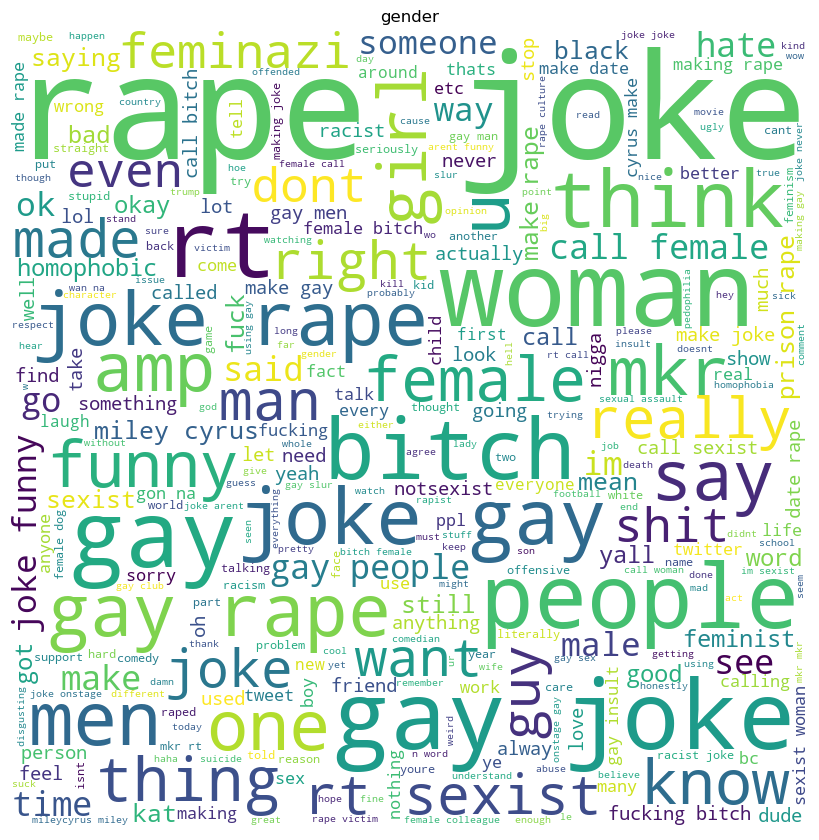

In [39]:
plot_wordcloud('gender', df)

##### Religion based cyberbullying

In [40]:
religion = Counter([item for sublist in df_religion['tokenized_text'] for item in sublist])
top10_religion = pd.DataFrame(religion.most_common(15))
top10_religion.columns = ['Top Words', 'Count']
top10_religion.style.background_gradient(cmap='Reds')

,Top Words,Count
0,muslim,4638
1,idiot,3066
2,christian,2075
3,u,1947
4,terrorist,1384
5,right,1300
6,woman,1257
7,islamic,1254
8,like,1245
9,islam,1194


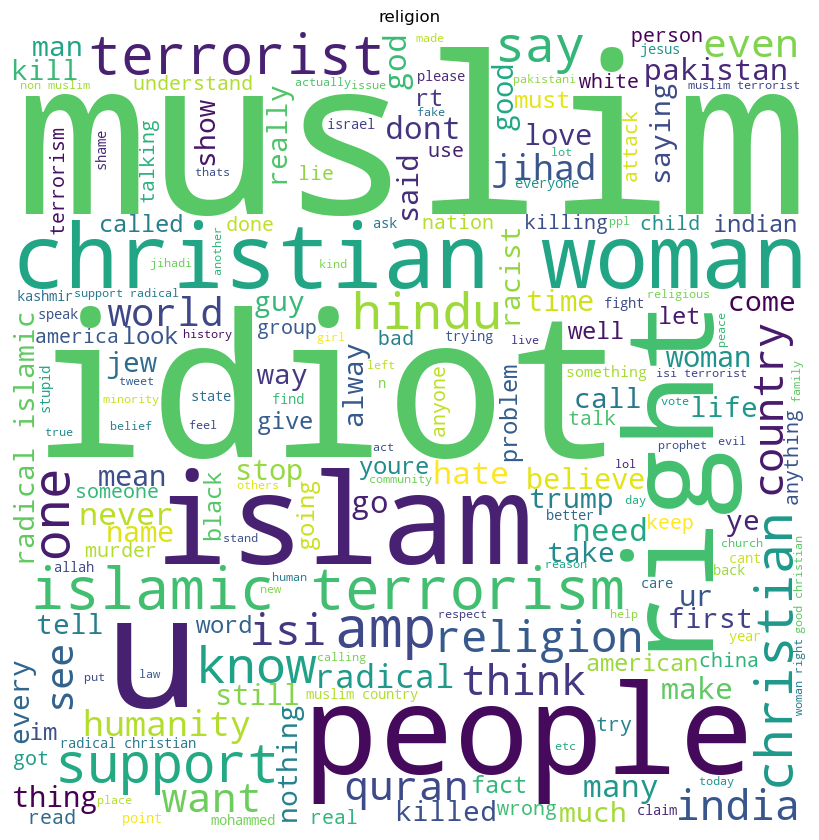

In [41]:
plot_wordcloud('religion', df)

##### Other types cyberbullying

In [42]:
other_cyberbullying = Counter([item for sublist in df_other_cyberbullying['tokenized_text'] for item in sublist])
top10_other_cyberbullying = pd.DataFrame(other_cyberbullying.most_common(15))
top10_other_cyberbullying.columns = ['Top Words', 'Count']
top10_other_cyberbullying.style.background_gradient(cmap='Reds')

,Top Words,Count
0,rt,736
1,bully,507
2,like,406
3,fucking,364
4,people,353
5,get,305
6,idiot,263
7,would,238
8,know,230
9,u,229


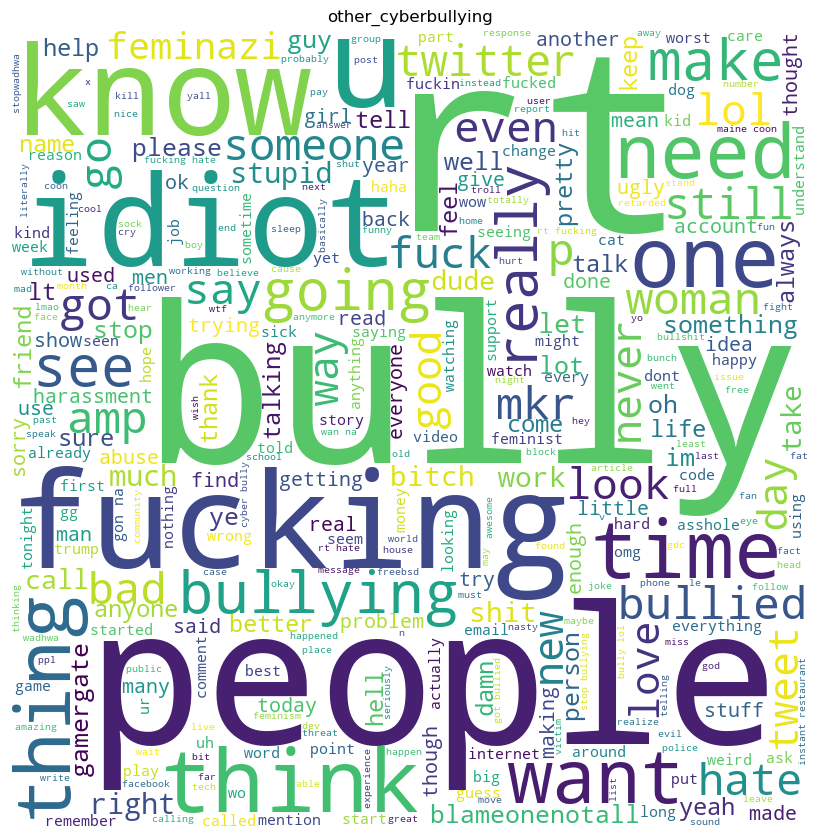

In [43]:
plot_wordcloud('other_cyberbullying', df)

##### age based cyberbullying

In [44]:
age = Counter([item for sublist in df_age['tokenized_text'] for item in sublist])
top10_age = pd.DataFrame(age.most_common(15))
top10_age.columns = ['Top Words', 'Count']
top10_age.style.background_gradient(cmap='Reds')

,Top Words,Count
0,school,8525
1,high,4945
2,girl,4665
3,bullied,4371
4,bully,4346
5,like,1888
6,one,1045
7,people,935
8,got,848
9,kid,807


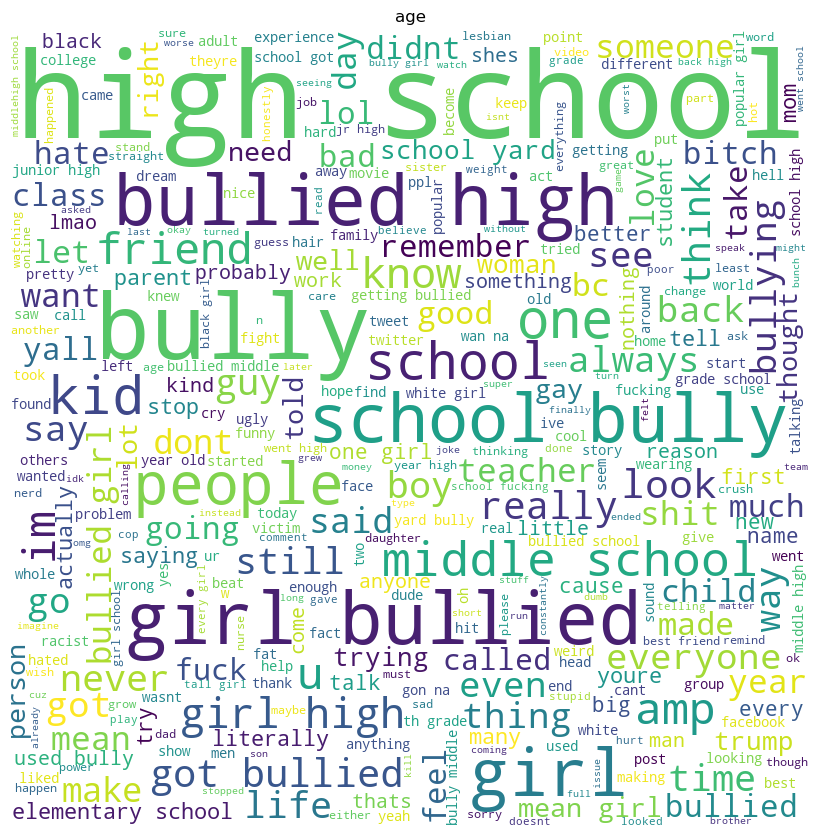

In [45]:
plot_wordcloud('age', df)

##### Ethnicity based cyberbullying

In [46]:
ethnicity = Counter([item for sublist in df_ethnicity['tokenized_text'] for item in sublist])
top10_ethnicity = pd.DataFrame(ethnicity.most_common(10))
top10_ethnicity.columns = ['Top Words', 'Count']
top10_ethnicity.style.background_gradient(cmap='Reds')

,Top Words,Count
0,nigger,5615
1,fuck,5407
2,dumb,5161
3,as,2268
4,black,2148
5,u,2126
6,white,1569
7,rt,1188
8,people,1187
9,obama,1144


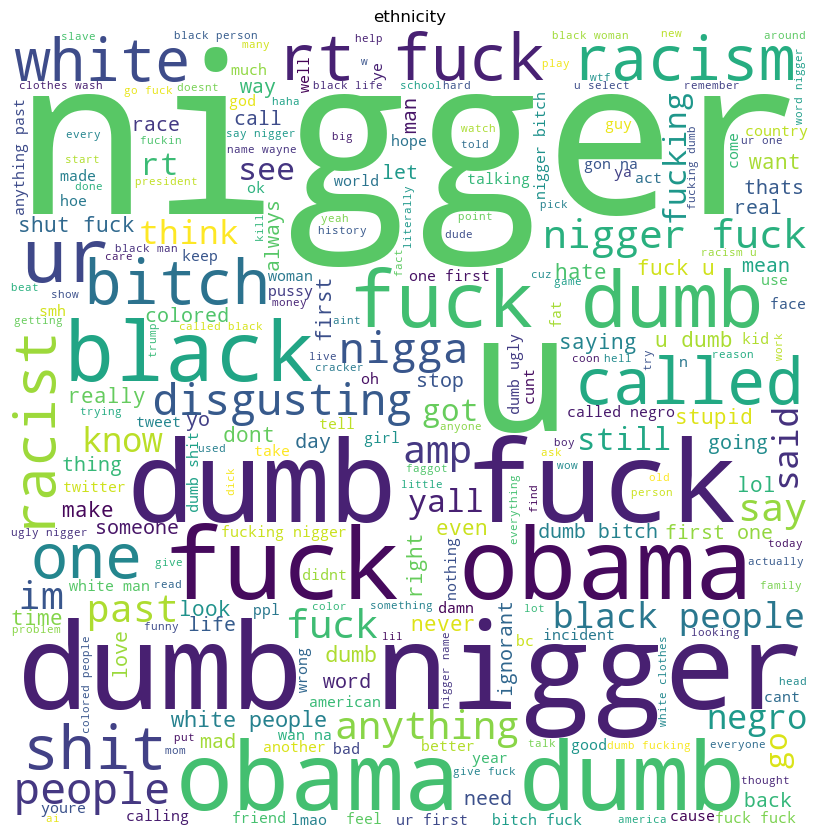

In [47]:
plot_wordcloud('ethnicity', df)

In [48]:
# Define a dictionary that maps sentiment categories to integer values
sentiment_map = {'not_cyberbullying': 1, 'gender': 2, 'religion': 3, 'other_cyberbullying': 4, 'age': 5, 'ethnicity': 6}
sentiment_list = list(sentiment_map.keys())
df['sentiment_int'] = df['sentiment'].map(sentiment_map)
df.head()

,text,sentiment,cleaned_text,tokenized_text,text_len,sentiment_int
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,"[word, katandandre, food, crapilicious, mkr]",5,1
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,"[aussietv, white, mkr, theblock, imacelebritya...",11,1
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,"[classy, whore, red, velvet, cupcake]",5,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks head concerned another angry dude...,"[meh, p, thanks, head, concerned, another, ang...",9,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,"[isi, account, pretending, kurdish, account, l...",8,1


#### Split data into train test split

In [49]:
X = df['cleaned_text']
y = df['sentiment_int']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify =y, random_state = 42)

In [50]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (35896,)
Shape of y_train: (35896,)


In [51]:
# Create a HashingVectorizer object with desired parameters
vectorizer = HashingVectorizer(n_features=10000, ngram_range=(1, 3),alternate_sign=True)

# Fit the vectorizer to the training data
X_train_vect = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer object
X_test_vect = vectorizer.transform(X_test)

# Print the shape of the vectorized training data
print("Shape of X_train_vect:", X_train_vect.shape)

# Print the shape of the vectorized test data
print("Shape of X_test_vect:", X_test_vect.shape)

Shape of X_train_vect: (35896, 10000)
Shape of X_test_vect: (8974, 10000)


#### Modelling

###### Logistic Regression

In [52]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000)

# Fit the logistic regression model to the training data
lr.fit(X_train_vect, y_train)

LogisticRegression(max_iter=2000)

In [53]:
# Use the fitted model to make predictions on the test data
y_pred_lr = lr.predict(X_test_vect)

# Calculate the accuracy, precision, and recall of the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

# Print the evaluation results for the logistic regression model
print("Accuracy of Logistic Regression: {:.2f}".format(accuracy_lr))
print("Precision of Logistic Regression: {:.2f}".format(precision_lr))
print("Recall of Logistic Regression: {:.2f}".format(recall_lr))

# Create a DataFrame to store the evaluation results of all models
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])
# Add the evaluation results of the Logistic Regression model to the DataFrame
results = results.append({'Model': 'Logistic Regression', 'Accuracy': accuracy_lr,
                          'Precision': precision_lr, 'Recall': recall_lr}, ignore_index=True)

Accuracy of Logistic Regression: 0.83
Precision of Logistic Regression: 0.83
Recall of Logistic Regression: 0.83


###### Decision Tree

In [54]:
## Decision Tree
dtc = DecisionTreeClassifier(random_state=42)

# Fit the decision tree classifier to the training data
dtc.fit(X_train_vect, y_train)

DecisionTreeClassifier(random_state=42)

In [55]:
y_pred_dtc = dtc.predict(X_test_vect)

accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
precision_dtc = precision_score(y_test, y_pred_dtc, average='weighted')
recall_dtc = recall_score(y_test, y_pred_dtc, average='weighted')

In [56]:
print("Accuracy of Decision Tree: {:.2f}".format(accuracy_dtc))
print("Precision of Decision Tree: {:.2f}".format(precision_dtc))
print("Recall of Decision Tree: {:.2f}".format(recall_dtc))


# Add the evaluation results of the Decision Tree Classifier model to the DataFrame
results = results.append({'Model': 'Decision Tree Classifier', 'Accuracy': accuracy_dtc,
                          'Precision': precision_dtc, 'Recall': recall_dtc}, ignore_index=True)

Accuracy of Decision Tree: 0.82
Precision of Decision Tree: 0.83
Recall of Decision Tree: 0.82


###### Random Forest

In [57]:
# Using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the random forest model to the training data
rf.fit(X_train_vect, y_train)

# Use the fitted model to make predictions on the test data
y_pred_rf = rf.predict(X_test_vect)

# Calculate the accuracy, precision, and recall of the random forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

In [58]:
print("Accuracy of Random Forest: {:.2f}".format(accuracy_rf))
print("Precision of Random Forest: {:.2f}".format(precision_rf))
print("Recall of Random Forest: {:.2f}".format(recall_rf))

# Add the evaluation results of the Random Forest model to the DataFrame
results = results.append({'Model': 'Random Forest', 'Accuracy': accuracy_rf,
                          'Precision': precision_rf, 'Recall': recall_rf}, ignore_index=True)

Accuracy of Random Forest: 0.85
Precision of Random Forest: 0.85
Recall of Random Forest: 0.85


###### SVC

In [59]:
# SVC
svc = SVC(C=1, kernel='linear', random_state=42)

# Fit the SVM model to the training data
svc.fit(X_train_vect, y_train)
y_pred_svc = svc.predict(X_test_vect)

# Calculate the accuracy, precision, and recall of the SVM model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')

In [60]:
print("Accuracy of SVC: {:.2f}".format(accuracy_svc))
print("Precision of SVC: {:.2f}".format(precision_svc))
print("Recall of SVC: {:.2f}".format(recall_svc))


# Add the evaluation results of the SVC model to the DataFrame
results = results.append({'Model': 'SVC', 'Accuracy': accuracy_svc,
                          'Precision': precision_svc, 'Recall': recall_svc}, ignore_index=True)

Accuracy of SVC: 0.83
Precision of SVC: 0.84
Recall of SVC: 0.83


###### Stochastic Gradient Descent

In [61]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=2000, random_state=42)

# Fit the SGD classifier to the training data
sgd.fit(X_train_vect, y_train)

# Use the fitted model to make predictions on the test data
y_pred_sgd = sgd.predict(X_test_vect)

In [62]:
# Calculate the accuracy, precision, and recall of the SGD classifier
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
precision_sgd = precision_score(y_test, y_pred_sgd, average='weighted')
recall_sgd = recall_score(y_test, y_pred_sgd, average='weighted')

In [63]:
print("Accuracy of SGD: {:.2f}".format(accuracy_sgd))
print("Precision of SGD: {:.2f}".format(precision_sgd))
print("Recall of SGD: {:.2f}".format(recall_sgd))


# Add the evaluation results of the Stochastic Gradient Descent model to the DataFrame
results = results.append({'Model': 'Stochastic Gradient Descent', 'Accuracy': accuracy_sgd,
                          'Precision': precision_sgd, 'Recall': recall_sgd}, ignore_index=True)

Accuracy of SGD: 0.78
Precision of SGD: 0.76
Recall of SGD: 0.78


###### Adaboost

In [64]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the AdaBoost classifier to the training data
ada.fit(X_train_vect, y_train)

# Use the fitted model to make predictions on the test data
y_pred_ada = ada.predict(X_test_vect)

In [65]:
# Calculate the accuracy, precision, and recall of the AdaBoost classifier
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')

print("Accuracy of ADA: {:.2f}".format(accuracy_ada))
print("Precision of ADA: {:.2f}".format(precision_ada))
print("Recall of ADA: {:.2f}".format(recall_ada))

# Add the evaluation results of the AdaBoost classifier to the DataFrame
results = results.append({'Model': 'AdaBoost Classifier', 'Accuracy': accuracy_ada,
                          'Precision': precision_ada, 'Recall': recall_ada}, ignore_index=True)

Accuracy of ADA: 0.80
Precision of ADA: 0.81
Recall of ADA: 0.80


In [66]:
results

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.826053,0.831667,0.826053
1,Decision Tree Classifier,0.823713,0.828375,0.823713
2,Random Forest,0.845108,0.847639,0.845108
3,SVC,0.828059,0.837369,0.828059
4,Stochastic Gradient Descent,0.778137,0.756005,0.778137
5,AdaBoost Classifier,0.799421,0.813717,0.799421


###### Playing with GridSearchCV

In [67]:
# Define the hyperparameter grid for logistic regression
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 5, 7, 10, 100]}

lr = LogisticRegression(random_state=42)

grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search_lr.fit(X_train_vect, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best hyperparameters: {'C': 1, 'penalty': 'l2'}
Best score: 0.8234064807561206


In [68]:
# Define the hyperparameter grid for decision tree
param_grid = {'max_depth': [3, 5, None], 'min_samples_split': [1, 10], 
              'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']}

dtc = DecisionTreeClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search_dtc.fit(X_train_vect, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search_dtc.best_params_)
print('Best score:', grid_search_dtc.best_score_)

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.7677174217124304


In [69]:
# Define the hyperparameter grid for randomForest
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [None, 5,],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2]}

# Create an instance of RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search_rfc.fit(X_train_vect, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search_rfc.best_params_)
print('Best score:', grid_search_rfc.best_score_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 0.8436870964950774


In [70]:
# Define the hyperparameter grid for SVC
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [0.1, 1], 
              'kernel': ['linear', 'rbf']}
svc = SVC()

# Create an instance of GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search_svc.fit(X_train_vect, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search_svc.best_params_)
print('Best score:', grid_search_svc.best_score_)

Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.8296187852142255


###### We've limited the parameter search to a smaller subset due to time and resource constraints. Unfortunately, the performance of the tuned model is slightly worse than that of the original model. We could try tuning more parameters, but the additional search would take a long time to run, so we are stopping the search here and accepting the suboptimal performance.